In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
DB_NAME = 'airbnb_nyc.db'
CSV_FILE = 'AB_NYC_2019.csv'

In [15]:
def load_and_preprocess_data(csv_filepath):
#Loads the CSV and performs initial NaN filling
    if not os.path.exists(csv_filepath):
        print(f"CRITICAL ERROR: {csv_filepath} not found.")
        return None
    try:
        df = pd.read_csv(csv_filepath)
        print(f"Original CSV loaded. Shape: {df.shape}")

        if 'reviews_per_month' in df.columns:
            df['reviews_per_month'] = df['reviews_per_month'].fillna(value=0)
        else:
            print("WARNING: 'reviews_per_month' column not found in CSV.")
        if 'name' in df.columns:
            df['name'] = df['name'].fillna(value='N/A')
        else:
            print("WARNING: 'name' column not found in CSV.")

        if 'host_name' in df.columns:
            df['host_name'] = df['host_name'].fillna(value='N/A')
        else:
            print("WARNING: 'host_name' column not found in CSV.")

        print("Initial data preprocessing of df_original complete.")
        return df
    except Exception as e:
        print(f"Error loading or preprocessing data: {e}")
        return None

In [5]:
def setup_database_schema(conn):
    """Drops existing tables and creates the new schema."""
    cursor = conn.cursor()
    try:
        #Dropping old tables (if they existed)
        cursor.execute("DROP TABLE IF EXISTS Listings")
        cursor.execute("DROP TABLE IF EXISTS Hosts")
        cursor.execute("DROP TABLE IF EXISTS Neighbourhoods")
        cursor.execute("DROP TABLE IF EXISTS NeighbourhoodGroups")
        cursor.execute("DROP TABLE IF EXISTS RoomTypes")
        conn.commit()

        #Creating new database tables
        cursor.execute('''CREATE TABLE Hosts (host_id INTEGER PRIMARY KEY, host_name TEXT)''')
        cursor.execute('''CREATE TABLE NeighbourhoodGroups (neighbourhood_group_id INTEGER PRIMARY KEY AUTOINCREMENT, neighbourhood_group_name TEXT UNIQUE NOT NULL)''')
        cursor.execute('''CREATE TABLE Neighbourhoods (neighbourhood_id INTEGER PRIMARY KEY AUTOINCREMENT, neighbourhood_name TEXT UNIQUE NOT NULL, neighbourhood_group_id INTEGER, FOREIGN KEY (neighbourhood_group_id) REFERENCES NeighbourhoodGroups(neighbourhood_group_id))''')
        cursor.execute('''CREATE TABLE RoomTypes (room_type_id INTEGER PRIMARY KEY AUTOINCREMENT, room_type_name TEXT UNIQUE NOT NULL)''')
        cursor.execute('''CREATE TABLE Listings (id INTEGER PRIMARY KEY, name TEXT, host_id INTEGER, neighbourhood_id INTEGER, room_type_id INTEGER, latitude REAL, longitude REAL, price INTEGER, minimum_nights INTEGER, number_of_reviews INTEGER, last_review TEXT, reviews_per_month REAL, calculated_host_listings_count INTEGER, availability_365 INTEGER, FOREIGN KEY (host_id) REFERENCES Hosts(host_id), FOREIGN KEY (neighbourhood_id) REFERENCES Neighbourhoods(neighbourhood_id), FOREIGN KEY (room_type_id) REFERENCES RoomTypes(room_type_id))''')
        conn.commit()
        print("Database tables created successfully.")
        return True
    except sqlite3.Error as e:
        print(f"SQLite error during schema setup: {e}")
        conn.rollback()
        return False
    finally:
        cursor.close()


In [6]:
def populate_dimension_tables(conn, df_original):
    """Populates Hosts, NeighbourhoodGroups, Neighbourhoods, RoomTypes tables.
       Returns mapping dictionaries: ng_map, n_map, rt_map.
    """
    cursor = conn.cursor()
    maps = {"ng_map": {}, "n_map": {}, "rt_map": {}}

    try:
        #Populating the Hosts table
        print("\nPopulating Hosts...")
        hosts_df = df_original[['host_id', 'host_name']].drop_duplicates(subset=['host_id']).copy()
        hosts_df = hosts_df.dropna(subset=['host_id'])
        if not hosts_df.empty:
            hosts_df['host_id'] = hosts_df['host_id'].astype(int)
            hosts_df.to_sql('Hosts_temp', conn, if_exists='replace', index=False)
            cursor.execute("INSERT OR IGNORE INTO Hosts (host_id, host_name) SELECT host_id, host_name FROM Hosts_temp")
            cursor.execute("DROP TABLE Hosts_temp")
            conn.commit()
        count_hosts = cursor.execute('SELECT COUNT(*) FROM Hosts').fetchone()[0]
        print(f"Populated Hosts table. Count: {count_hosts}")
        if count_hosts == 0: print("WARNING: Hosts table is empty!")

        #Populating the NeighbourhoodGroups table
        print("\nPopulating NeighbourhoodGroups...")
        ng_df = pd.DataFrame(df_original['neighbourhood_group'].unique(), columns=['neighbourhood_group_name'])
        ng_df = ng_df.dropna(subset=['neighbourhood_group_name'])
        if not ng_df.empty:
            ng_df.to_sql('NeighbourhoodGroups_temp', conn, if_exists='replace', index=False)
            cursor.execute("INSERT OR IGNORE INTO NeighbourhoodGroups (neighbourhood_group_name) SELECT neighbourhood_group_name FROM NeighbourhoodGroups_temp")
            cursor.execute("DROP TABLE NeighbourhoodGroups_temp")
            conn.commit()
        count_ng = cursor.execute('SELECT COUNT(*) FROM NeighbourhoodGroups').fetchone()[0]
        print(f"Populated NeighbourhoodGroups table. Count: {count_ng}")
        if count_ng > 0:
            ng_map_df = pd.read_sql_query("SELECT neighbourhood_group_id, neighbourhood_group_name FROM NeighbourhoodGroups", conn)
            if not ng_map_df.empty: maps["ng_map"] = ng_map_df.set_index('neighbourhood_group_name')['neighbourhood_group_id'].to_dict()
        print(f"DEBUG: ng_map created. Size: {len(maps['ng_map'])}.")


        #Populating the Neighbourhoods table
        print("\nPopulating Neighbourhoods...")
        neighbourhoods_df = df_original[['neighbourhood', 'neighbourhood_group']].drop_duplicates().copy()
        neighbourhoods_df = neighbourhoods_df.dropna(subset=['neighbourhood'])
        if not neighbourhoods_df.empty and maps["ng_map"]:
            neighbourhoods_df['neighbourhood_group_id'] = neighbourhoods_df['neighbourhood_group'].map(maps["ng_map"])
            neighbourhoods_df_final = neighbourhoods_df.dropna(subset=['neighbourhood_group_id'])
            if not neighbourhoods_df_final.empty:
                neighbourhoods_df_final = neighbourhoods_df_final[['neighbourhood', 'neighbourhood_group_id']].rename(columns={'neighbourhood': 'neighbourhood_name'})
                neighbourhoods_df_final['neighbourhood_group_id'] = neighbourhoods_df_final['neighbourhood_group_id'].astype(int)
                neighbourhoods_df_final = neighbourhoods_df_final.drop_duplicates(subset=['neighbourhood_name'])
                neighbourhoods_df_final.to_sql('Neighbourhoods_temp', conn, if_exists='replace', index=False)
                cursor.execute("INSERT OR IGNORE INTO Neighbourhoods (neighbourhood_name, neighbourhood_group_id) SELECT neighbourhood_name, neighbourhood_group_id FROM Neighbourhoods_temp")
                cursor.execute("DROP TABLE Neighbourhoods_temp")
                conn.commit()
        count_n = cursor.execute('SELECT COUNT(*) FROM Neighbourhoods').fetchone()[0]
        print(f"Populated Neighbourhoods table. Count: {count_n}")
        if count_n > 0:
            n_map_df = pd.read_sql_query("SELECT neighbourhood_id, neighbourhood_name FROM Neighbourhoods", conn)
            if not n_map_df.empty: maps["n_map"] = n_map_df.set_index('neighbourhood_name')['neighbourhood_id'].to_dict()
        print(f"DEBUG: n_map created. Size: {len(maps['n_map'])}.")

        #Populating the RoomTypes table
        print("\nPopulating RoomTypes...")
        rt_df = pd.DataFrame(df_original['room_type'].unique(), columns=['room_type_name'])
        rt_df = rt_df.dropna(subset=['room_type_name'])
        if not rt_df.empty:
            rt_df.to_sql('RoomTypes_temp', conn, if_exists='replace', index=False)
            cursor.execute("INSERT OR IGNORE INTO RoomTypes (room_type_name) SELECT room_type_name FROM RoomTypes_temp")
            cursor.execute("DROP TABLE RoomTypes_temp")
            conn.commit()
        count_rt = cursor.execute('SELECT COUNT(*) FROM RoomTypes').fetchone()[0]
        print(f"Populated RoomTypes table. Count: {count_rt}")
        if count_rt > 0:
            rt_map_df = pd.read_sql_query("SELECT room_type_id, room_type_name FROM RoomTypes", conn)
            if not rt_map_df.empty: maps["rt_map"] = rt_map_df.set_index('room_type_name')['room_type_id'].to_dict()
        print(f"DEBUG: rt_map created. Size: {len(maps['rt_map'])}.")

        return maps

    except sqlite3.Error as e:
        print(f"SQLite error during dimension table population: {e}")
        conn.rollback()
        return maps # Return potentially partially filled maps or empty maps
    except Exception as e:
        print(f"General error during dimension table population: {e}")
        return maps
    finally:
        cursor.close()

In [7]:
def populate_listings_table(conn, df_original, n_map, rt_map):
    """Populates the Listings table using provided maps."""
    cursor = conn.cursor()
    try:
        print("\n--- Populating Listings ---")
        df_listings = df_original.copy()

        #Checking if maps are valid
        if not n_map: print("WARNING: n_map is empty. Neighbourhood IDs will not be mapped correctly for Listings.")
        if not rt_map: print("WARNING: rt_map is empty. Room Type IDs will not be mapped correctly for Listings.")

        df_listings['neighbourhood_id_mapped'] = df_listings['neighbourhood'].map(n_map if n_map else {})
        df_listings['room_type_id_mapped'] = df_listings['room_type'].map(rt_map if rt_map else {})

        df_listings = df_listings.dropna(subset=['host_id']) # host_id should be directly from CSV
        if not df_listings.empty:
            df_listings['host_id'] = df_listings['host_id'].astype(int)

        #Filtering by valid host_ids from Hosts table (ensure Hosts table is populated)
        valid_host_ids_df = pd.read_sql_query("SELECT host_id FROM Hosts", conn)
        if valid_host_ids_df.empty:
            print("CRITICAL WARNING: Hosts table is empty in DB, cannot validate host_id for Listings.")
            valid_host_ids = set()
        else:
            valid_host_ids = set(valid_host_ids_df['host_id'])

        df_listings = df_listings[df_listings['host_id'].isin(valid_host_ids)]
        df_listings = df_listings.dropna(subset=['neighbourhood_id_mapped', 'room_type_id_mapped'])

        df_listings_final = pd.DataFrame()
        if not df_listings.empty:
            df_listings = df_listings.rename(columns={
                'neighbourhood_id_mapped': 'neighbourhood_id',
                'room_type_id_mapped': 'room_type_id'
            })
            df_listings['neighbourhood_id'] = df_listings['neighbourhood_id'].astype(int)
            df_listings['room_type_id'] = df_listings['room_type_id'].astype(int)

            required_columns = ['id', 'name', 'host_id', 'neighbourhood_id', 'room_type_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
            actual_cols_for_final = [col for col in required_columns if col in df_listings.columns]

            if len(actual_cols_for_final) == len(required_columns):
                df_listings_final = df_listings[required_columns].copy()
                df_listings_final = df_listings_final.drop_duplicates(subset=['id'], keep='first')
            else:
                print(f"CRITICAL DEBUG: Not all required columns for Listings present. Missing: {set(required_columns) - set(actual_cols_for_final)}")

        print(f"DEBUG: df_listings_final shape before insert: {df_listings_final.shape}")
        if not df_listings_final.empty:
            df_listings_final.to_sql('Listings_temp', conn, if_exists='replace', index=False)
            cursor.execute("INSERT OR IGNORE INTO Listings SELECT * FROM Listings_temp")
            cursor.execute("DROP TABLE Listings_temp")
            conn.commit()
        else:
            print("CRITICAL: df_listings_final is empty. No data to insert into Listings table.")

        count_l = cursor.execute('SELECT COUNT(*) FROM Listings').fetchone()[0]
        print(f"Populated Listings table. Count: {count_l}")
        return count_l > 0 # Return True if listings were populated

    except sqlite3.Error as e:
        print(f"SQLite error during Listings population: {e}")
        conn.rollback()
        return False
    except Exception as e:
        print(f"General error during Listings population: {e}")
        return False
    finally:
        cursor.close()

In [8]:
def load_analysis_helper_dfs(conn):
    """Loads dimension tables from DB into pandas DataFrames for analysis."""
    print("\nLoading helper DataFrames for analysis...")
    try:
        dfs = {
            "df_neighbourhoods_global": pd.read_sql_query("SELECT neighbourhood_id, neighbourhood_name, neighbourhood_group_id FROM Neighbourhoods", conn),
            "df_groups_global": pd.read_sql_query("SELECT neighbourhood_group_id, neighbourhood_group_name FROM NeighbourhoodGroups", conn),
            "df_room_types_global": pd.read_sql_query("SELECT room_type_id, room_type_name FROM RoomTypes", conn),
            "df_hosts_global": pd.read_sql_query("SELECT host_id, host_name FROM Hosts", conn)
        }
        for name, df_item in dfs.items():
            if df_item.empty:
                print(f"WARNING: {name} is empty after loading from DB.")
        print("Helper DataFrames for analysis loaded.")
        return dfs
    except Exception as e:
        print(f"Error loading helper DataFrames for analysis: {e}")
        return {key: pd.DataFrame() for key in ["df_neighbourhoods_global", "df_groups_global", "df_room_types_global", "df_hosts_global"]}

In [9]:
def run_q1_analysis(conn, helper_dfs):
    q1_sql_result = pd.DataFrame()
    try:
        q1_sql_query = """
            SELECT ng.neighbourhood_group_name, n.neighbourhood_name, COUNT(l.id) AS number_of_listings, ROUND(AVG(l.price), 2) AS average_price
            FROM Listings l JOIN Neighbourhoods n ON l.neighbourhood_id = n.neighbourhood_id JOIN NeighbourhoodGroups ng ON n.neighbourhood_group_id = ng.neighbourhood_group_id
            GROUP BY ng.neighbourhood_group_name, n.neighbourhood_name ORDER BY average_price DESC, number_of_listings DESC LIMIT 20;"""
        q1_sql_result = pd.read_sql_query(q1_sql_query, conn)
        print("SQL Result (Top 20 by Avg Price):"); print(q1_sql_result if not q1_sql_result.empty else "SQL Q1 Result is empty.")

        if not helper_dfs["df_neighbourhoods_global"].empty and not helper_dfs["df_groups_global"].empty:
            df_listings_q1 = pd.read_sql_query("SELECT id, price, neighbourhood_id FROM Listings", conn)
            if not df_listings_q1.empty:
                merged_q1 = pd.merge(df_listings_q1, helper_dfs["df_neighbourhoods_global"], on='neighbourhood_id', how='inner')
                merged_q1 = pd.merge(merged_q1, helper_dfs["df_groups_global"], on='neighbourhood_group_id', how='inner')
                if not merged_q1.empty:
                    pandas_q1 = merged_q1.groupby(['neighbourhood_group_name', 'neighbourhood_name']).agg(
                        number_of_listings=('id', 'count'), average_price=('price', 'mean')
                    ).sort_values(by=['average_price', 'number_of_listings'], ascending=[False, False]).reset_index()
                    pandas_q1['average_price'] = pandas_q1['average_price'].round(2)
                    print("\nPandas Result (Top 20 by Avg Price):"); print(pandas_q1.head(20))
                else: print("Pandas Q1: Merged DataFrame is empty.")
            else: print("Pandas Q1: Listings data for Q1 is empty.")
        else: print("Pandas Q1: Skipping due to missing helper tables for Q1.")

        if not q1_sql_result.empty:
            plt.figure(figsize=(12, 8))
            sns.barplot(data=q1_sql_result.head(10), x='average_price', y='neighbourhood_name', hue='neighbourhood_group_name', dodge=False)
            plt.title('Top 10 NYC Neighbourhoods by Average Airbnb Price (2019 Data)'); plt.xlabel('Average Price ($)'); plt.ylabel('Neighbourhood')
            plt.legend(title='Borough'); plt.tight_layout(); plt.savefig('investor_q1_visual.png'); print("Saved investor_q1_visual.png")
            plt.show(); plt.close() # Show then close
    except Exception as e: print(f"Error during Q1: {e}")

In [10]:
def run_q2_analysis(conn, helper_dfs):
    q2_sql_result = pd.DataFrame()
    try:
        q2_sql_query = """
            WITH TopNeighbourhoodGroups AS (
                SELECT ng.neighbourhood_group_id, ng.neighbourhood_group_name, AVG(l.price) as avg_group_price
                FROM Listings l JOIN Neighbourhoods n ON l.neighbourhood_id = n.neighbourhood_id JOIN NeighbourhoodGroups ng ON n.neighbourhood_group_id = ng.neighbourhood_group_id
                GROUP BY ng.neighbourhood_group_id, ng.neighbourhood_group_name ORDER BY avg_group_price DESC LIMIT 3
            )
            SELECT tng.neighbourhood_group_name, rt.room_type_name, COUNT(l.id) AS number_of_listings, ROUND(AVG(l.price), 2) AS average_price,
                   ROUND(AVG(l.price * l.availability_365), 2) AS estimated_annual_revenue_potential_per_listing
            FROM Listings l JOIN Neighbourhoods n ON l.neighbourhood_id = n.neighbourhood_id
            JOIN RoomTypes rt ON l.room_type_id = rt.room_type_id JOIN TopNeighbourhoodGroups tng ON n.neighbourhood_group_id = tng.neighbourhood_group_id
            GROUP BY tng.neighbourhood_group_name, rt.room_type_name ORDER BY tng.neighbourhood_group_name, estimated_annual_revenue_potential_per_listing DESC;"""
        q2_sql_result = pd.read_sql_query(q2_sql_query, conn)
        print("SQL Result:"); print(q2_sql_result if not q2_sql_result.empty else "SQL Q2 Result is empty.")

        if not helper_dfs["df_neighbourhoods_global"].empty and \
           not helper_dfs["df_groups_global"].empty and \
           not helper_dfs["df_room_types_global"].empty:
            df_listings_q2 = pd.read_sql_query("SELECT price, availability_365, room_type_id, neighbourhood_id FROM Listings", conn)
            if not df_listings_q2.empty:
                merged_for_top_groups = pd.merge(df_listings_q2, helper_dfs["df_neighbourhoods_global"], on='neighbourhood_id', how='inner')
                merged_for_top_groups = pd.merge(merged_for_top_groups, helper_dfs["df_groups_global"], on='neighbourhood_group_id', how='inner')
                if not merged_for_top_groups.empty:
                    top_groups_names_series = merged_for_top_groups.groupby('neighbourhood_group_name')['price'].mean().nlargest(3)
                    if not top_groups_names_series.empty:
                        top_groups_names = top_groups_names_series.index.tolist()
                        filtered_q2 = merged_for_top_groups[merged_for_top_groups['neighbourhood_group_name'].isin(top_groups_names)]
                        merged_q2 = pd.merge(filtered_q2, helper_dfs["df_room_types_global"], on='room_type_id', how='inner')
                        if not merged_q2.empty:
                            merged_q2['estimated_annual_revenue_potential_per_listing'] = merged_q2['price'] * merged_q2['availability_365']
                            pandas_q2 = merged_q2.groupby(['neighbourhood_group_name', 'room_type_name']).agg(
                                number_of_listings=('price', 'count'), average_price=('price', 'mean'),
                                estimated_annual_revenue_potential_per_listing=('estimated_annual_revenue_potential_per_listing', 'mean')
                            ).sort_values(by=['neighbourhood_group_name', 'estimated_annual_revenue_potential_per_listing'], ascending=[True, False]).reset_index()
                            pandas_q2['average_price'] = pandas_q2['average_price'].round(2)
                            pandas_q2['estimated_annual_revenue_potential_per_listing'] = pandas_q2['estimated_annual_revenue_potential_per_listing'].round(2)
                            print("\nPandas Result:"); print(pandas_q2)
                        else: print("Pandas Q2: Final merge for aggregation resulted in empty DataFrame.")
                    else: print("Pandas Q2: Could not determine top groups.")
                else: print("Pandas Q2: Merged DataFrame for top groups is empty.")
            else: print("Pandas Q2: Listings data for Q2 (df_listings_q2) is empty.")
        else:
            print("Pandas Q2: Skipping Pandas equivalent due to missing helper tables.")

        if not q2_sql_result.empty:
            g = sns.catplot(data=q2_sql_result, x='room_type_name', y='estimated_annual_revenue_potential_per_listing', hue='neighbourhood_group_name', kind='bar', errorbar=None, aspect=1.5)
            if hasattr(g, 'legend') and g.legend is not None: g.legend.set_title('Neighbourhood Group')
            g.set_axis_labels("Room Type", "Estimated Annual Revenue Potential ($)"); g.fig.suptitle('Est. Annual Revenue Potential by Room Type in Top Neighbourhood Groups (2019 Data)', y=1.03)
            g.set_xticklabels(rotation=15, ha='right'); plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig('investor_q2_visual.png'); print("Saved investor_q2_visual.png")
            plt.show(); plt.close()
    except Exception as e:
        print(f"Error during Q2 processing: {e}")


In [11]:
def run_q3_analysis(conn, helper_dfs):
    print("\n--- Q3 (Investor): High-Velocity Neighbourhoods (Reviews/Month >= 1) ---")
    q3_sql_result = pd.DataFrame()
    try:
        q3_sql_query = """
            SELECT n.neighbourhood_name, ng.neighbourhood_group_name, COUNT(l.id) AS number_of_high_velocity_listings,
                   ROUND(AVG(l.reviews_per_month), 2) AS avg_reviews_per_month_for_these, ROUND(AVG(l.price), 2) AS avg_price_for_these
            FROM Listings l JOIN Neighbourhoods n ON l.neighbourhood_id = n.neighbourhood_id JOIN NeighbourhoodGroups ng ON n.neighbourhood_group_id = ng.neighbourhood_group_id
            WHERE l.reviews_per_month >= 1.0 GROUP BY n.neighbourhood_name, ng.neighbourhood_group_name
            ORDER BY avg_reviews_per_month_for_these DESC, number_of_high_velocity_listings DESC LIMIT 20;"""
        q3_sql_result = pd.read_sql_query(q3_sql_query, conn)
        print("SQL Result (Top 20):"); print(q3_sql_result if not q3_sql_result.empty else "SQL Q3 Result is empty.")

        if not helper_dfs["df_neighbourhoods_global"].empty and not helper_dfs["df_groups_global"].empty:
            df_listings_q3 = pd.read_sql_query("SELECT price, reviews_per_month, neighbourhood_id FROM Listings WHERE reviews_per_month >= 1.0", conn)
            if not df_listings_q3.empty:
                merged_q3 = pd.merge(df_listings_q3, helper_dfs["df_neighbourhoods_global"], on='neighbourhood_id', how='inner')
                merged_q3 = pd.merge(merged_q3, helper_dfs["df_groups_global"], on='neighbourhood_group_id', how='inner')
                if not merged_q3.empty:
                    pandas_q3 = merged_q3.groupby(['neighbourhood_name', 'neighbourhood_group_name']).agg(
                        number_of_high_velocity_listings=('price', 'count'), avg_reviews_per_month_for_these=('reviews_per_month', 'mean'), avg_price_for_these=('price', 'mean')
                    ).sort_values(by=['avg_reviews_per_month_for_these', 'number_of_high_velocity_listings'], ascending=[False, False]).reset_index()
                    pandas_q3['avg_reviews_per_month_for_these'] = pandas_q3['avg_reviews_per_month_for_these'].round(2)
                    pandas_q3['avg_price_for_these'] = pandas_q3['avg_price_for_these'].round(2)
                    print("\nPandas Result (Top 20):"); print(pandas_q3.head(20))
                else: print("Pandas Q3: Merged DataFrame is empty.")
            else: print("Pandas Q3: Listings data for Q3 (filtered) is empty.")
        else: print("Pandas Q3: Skipping due to missing helper tables.")

        if not q3_sql_result.empty:
            top_n_q3_plot = q3_sql_result.head(10)
            plt.figure(figsize=(13, 9)); barplot_q3 = sns.barplot(data=top_n_q3_plot, x='avg_reviews_per_month_for_these', y='neighbourhood_name', hue='neighbourhood_group_name', dodge=False)
            plt.title('Top 10 High-Velocity Neighbourhoods (Avg. Reviews/Month for Active Listings, 2019 Data)', pad=20)
            plt.xlabel('Average Reviews per Month (for listings with >=1 review/month)'); plt.ylabel('Neighbourhood')
            for i, bar_value in enumerate(top_n_q3_plot['avg_reviews_per_month_for_these']):
                plt.text(bar_value + 0.02, i, f"${top_n_q3_plot['avg_price_for_these'].iloc[i]:.0f}", va='center', ha='left', color='black', size=9)
            plt.legend(title='Borough', bbox_to_anchor=(1.02, 1), loc='upper left'); plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.savefig('investor_q3_visual.png'); print("Saved investor_q3_visual.png")
            plt.show(); plt.close()
    except Exception as e: print(f"Error during Q3: {e}")

def run_q4_analysis(conn, helper_dfs):
    q4_sql_result = pd.DataFrame()
    try:
        q4_sql_query = """
            SELECT h.host_name, h.host_id, COUNT(l.id) AS num_high_availability_listings, ROUND(AVG(l.price), 2) AS avg_price_of_these_listings
            FROM Listings l JOIN Hosts h ON l.host_id = h.host_id WHERE l.availability_365 > 200
            GROUP BY h.host_id, h.host_name ORDER BY num_high_availability_listings DESC LIMIT 5;"""
        q4_sql_result = pd.read_sql_query(q4_sql_query, conn)
        print("SQL Result:"); print(q4_sql_result if not q4_sql_result.empty else "SQL Q4 Result is empty.")

        if not helper_dfs["df_hosts_global"].empty:
            df_listings_q4 = pd.read_sql_query("SELECT host_id, price, availability_365 FROM Listings WHERE availability_365 > 200", conn)
            if not df_listings_q4.empty:
                merged_q4 = pd.merge(df_listings_q4, helper_dfs["df_hosts_global"], on='host_id', how='inner')
                if not merged_q4.empty:
                    pandas_q4 = merged_q4.groupby(['host_id', 'host_name']).agg(
                        num_high_availability_listings=('price', 'count'), avg_price_of_these_listings=('price', 'mean')
                    ).sort_values(by='num_high_availability_listings', ascending=False).head(5).reset_index()
                    pandas_q4['avg_price_of_these_listings'] = pandas_q4['avg_price_of_these_listings'].round(2)
                    print("\nPandas Result:"); print(pandas_q4)
                else: print("Pandas Q4: Merged DataFrame is empty.")
            else: print("Pandas Q4: Listings data for Q4 (filtered) is empty.")
        else: print("Pandas Q4: Skipping due to missing Hosts table.")

        if not q4_sql_result.empty:
            plt.figure(figsize=(10, 7)); barplot_q4 = sns.barplot(data=q4_sql_result, x='num_high_availability_listings', y='host_name', color='teal')
            plt.title('Top Hosts by Number of High-Availability Listings (>200 Days, 2019 Data)', pad=20)
            plt.xlabel('Number of High-Availability Listings'); plt.ylabel('Host Name (Top 5)')
            for i, bar_value in enumerate(q4_sql_result['num_high_availability_listings']):
                plt.text(bar_value - (0.05 * q4_sql_result['num_high_availability_listings'].max()), i, f"Avg Price: ${q4_sql_result['avg_price_of_these_listings'].iloc[i]:.0f}", color='white', ha="right", va="center", fontweight='bold', size=9)
            plt.tight_layout(); plt.savefig('investor_q4_visual.png'); print("Saved investor_q4_visual.png")
            plt.show(); plt.close()
    except Exception as e: print(f"Error during Q4: {e}")

def run_q5_analysis(conn, helper_dfs):
    print("\n--- Q5 (Investor): Min Stay Categories vs. Price & Demand by Neighbourhood Group ---")
    q5_sql_result = pd.DataFrame()
    try:
        q5_sql_query = """
            SELECT ng.neighbourhood_group_name,
                   CASE WHEN l.minimum_nights BETWEEN 1 AND 2 THEN 'Short (1-2 nights)' WHEN l.minimum_nights BETWEEN 3 AND 7 THEN 'Medium (3-7 nights)' ELSE 'Long (8+ nights)' END AS min_stay_category,
                   COUNT(l.id) AS number_of_listings, ROUND(AVG(l.price), 2) AS average_price, ROUND(AVG(l.reviews_per_month), 2) AS average_reviews_per_month
            FROM Listings l JOIN Neighbourhoods n ON l.neighbourhood_id = n.neighbourhood_id JOIN NeighbourhoodGroups ng ON n.neighbourhood_group_id = ng.neighbourhood_group_id
            GROUP BY ng.neighbourhood_group_name, min_stay_category ORDER BY ng.neighbourhood_group_name, average_price DESC;"""
        q5_sql_result = pd.read_sql_query(q5_sql_query, conn)
        print("SQL Result:"); print(q5_sql_result if not q5_sql_result.empty else "SQL Q5 Result is empty.")

        if not helper_dfs["df_neighbourhoods_global"].empty and not helper_dfs["df_groups_global"].empty:
            df_listings_q5 = pd.read_sql_query("SELECT minimum_nights, price, reviews_per_month, neighbourhood_id FROM Listings", conn)
            if not df_listings_q5.empty:
                merged_q5 = pd.merge(df_listings_q5, helper_dfs["df_neighbourhoods_global"], on='neighbourhood_id', how='inner')
                merged_q5 = pd.merge(merged_q5, helper_dfs["df_groups_global"], on='neighbourhood_group_id', how='inner')
                if not merged_q5.empty:
                    bins = [0, 2, 7, float('inf')]; labels = ['Short (1-2 nights)', 'Medium (3-7 nights)', 'Long (8+ nights)']
                    merged_q5['min_stay_category'] = pd.cut(merged_q5['minimum_nights'], bins=bins, labels=labels, right=True, include_lowest=True)
                    pandas_q5 = merged_q5.groupby(['neighbourhood_group_name', 'min_stay_category'], observed=False).agg(
                        number_of_listings=('price', 'count'), average_price=('price', 'mean'), average_reviews_per_month=('reviews_per_month', 'mean')
                    ).sort_values(by=['neighbourhood_group_name', 'average_price'], ascending=[True, False]).reset_index()
                    pandas_q5['average_price'] = pandas_q5['average_price'].round(2)
                    pandas_q5['average_reviews_per_month'] = pandas_q5['average_reviews_per_month'].round(2)
                    print("\nPandas Result:"); print(pandas_q5)
                else: print("Pandas Q5: Merged DataFrame is empty.")
            else: print("Pandas Q5: Listings data for Q5 is empty.")
        else: print("Pandas Q5: Skipping due to missing helper tables.")

        if not q5_sql_result.empty:
            q5_manhattan = q5_sql_result[q5_sql_result['neighbourhood_group_name'] == 'Manhattan'].copy()
            if not q5_manhattan.empty:
                category_order = ['Short (1-2 nights)', 'Medium (3-7 nights)', 'Long (8+ nights)']
                q5_manhattan['min_stay_category'] = pd.Categorical(q5_manhattan['min_stay_category'], categories=category_order, ordered=True)
                q5_manhattan = q5_manhattan.sort_values('min_stay_category')
                fig, ax1 = plt.subplots(figsize=(10, 7))
                sns.barplot(data=q5_manhattan, x='min_stay_category', y='average_price', palette='Blues', ax=ax1, order=category_order)
                ax1.set_ylabel('Average Price ($)'); ax1.set_xlabel('Minimum Stay Category (Manhattan)'); ax1.tick_params(axis='x', rotation=15)
                ax2 = ax1.twinx()
                sns.lineplot(data=q5_manhattan, x='min_stay_category', y='average_reviews_per_month', color='red', marker='o', ax=ax2, sort=False)
                ax2.set_ylabel('Average Reviews per Month')
                plt.title('Price & Demand by Min. Stay Category in Manhattan (2019 Data)', pad=20)
                from matplotlib.lines import Line2D; from matplotlib.patches import Patch
                legend_elements = [Patch(facecolor=sns.color_palette('Blues')[2], edgecolor='black', label='Average Price'), Line2D([0], [0], color='red', marker='o', linestyle='-', label='Avg Reviews/Month')]
                fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
                plt.tight_layout(rect=[0, 0.05, 1, 0.95]);
                plt.savefig('investor_q5_visual.png'); print("Saved investor_q5_visual.png")
                plt.show(); plt.close()
            else: print("Skipping Q5 visual as no Manhattan data found.")
    except Exception as e: print(f"Error during Q5: {e}")


Original CSV loaded. Shape: (48895, 16)
Initial data preprocessing of df_original complete.
Main: Database airbnb_nyc.db connected.
Dropping old tables (if they existed)...
Creating new database tables...
Database tables created successfully.

Populating Hosts...
Populated Hosts table. Count: 37457

Populating NeighbourhoodGroups...
Populated NeighbourhoodGroups table. Count: 5
DEBUG: ng_map created. Size: 5.

Populating Neighbourhoods...
Populated Neighbourhoods table. Count: 221
DEBUG: n_map created. Size: 221.

Populating RoomTypes...
Populated RoomTypes table. Count: 3
DEBUG: rt_map created. Size: 3.

--- Populating Listings ---
DEBUG: df_listings_final shape before insert: (48895, 14)
Populated Listings table. Count: 48895

Loading helper DataFrames for analysis...
Helper DataFrames for analysis loaded.

Main: Listings table has 48895 entries. Proceeding with analysis.

--- Q1 (Investor): Highest Avg Price Neighbourhoods & Density ---
SQL Result (Top 20 by Avg Price):
   neighbour

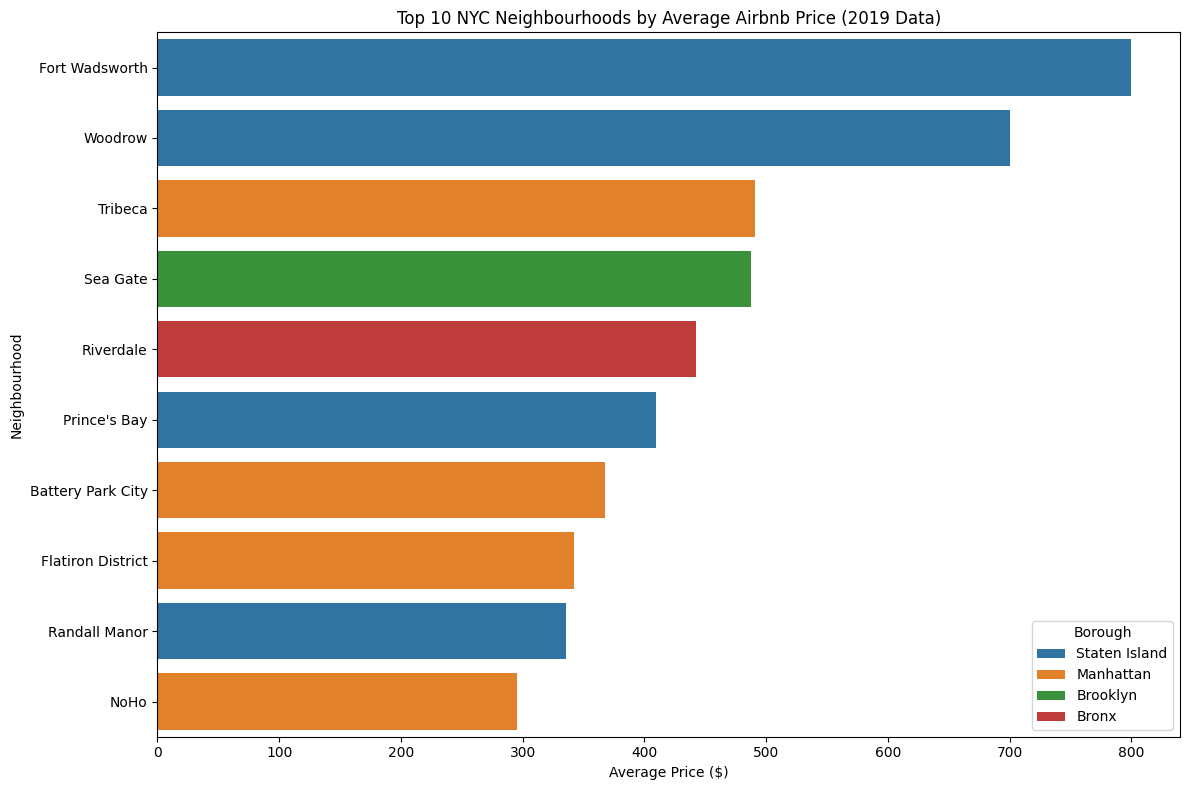


--- Q2 (Investor): Room Type Revenue Potential in Top 3 Expensive Groups ---
SQL Result:
  neighbourhood_group_name   room_type_name  number_of_listings  \
0                 Brooklyn  Entire home/apt                9559   
1                 Brooklyn     Private room               10132   
2                 Brooklyn      Shared room                 413   
3                Manhattan  Entire home/apt               13199   
4                Manhattan     Private room                7982   
5                Manhattan      Shared room                 480   
6            Staten Island  Entire home/apt                 176   
7            Staten Island     Private room                 188   
8            Staten Island      Shared room                   9   

   average_price  estimated_annual_revenue_potential_per_listing  
0         178.33                                        19906.58  
1          76.50                                         8497.99  
2          50.53                      

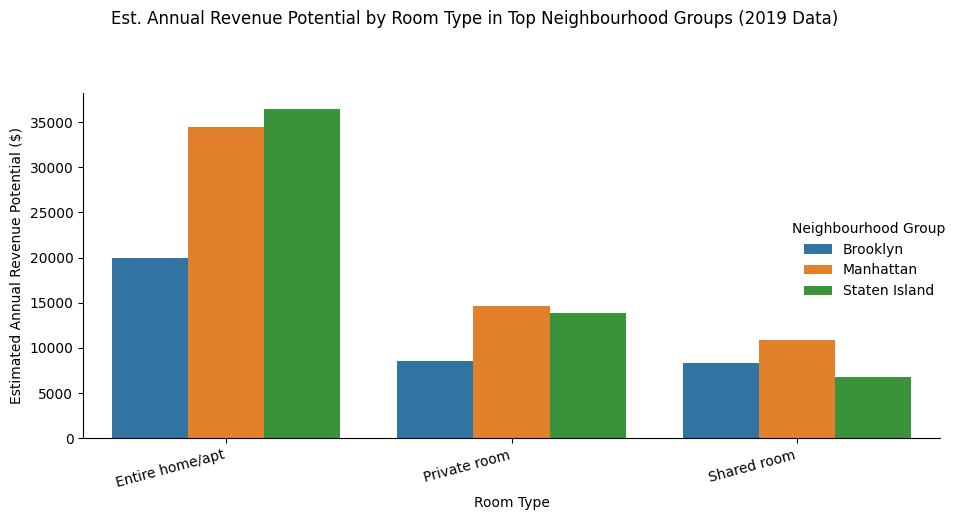


--- Q3 (Investor): High-Velocity Neighbourhoods (Reviews/Month >= 1) ---
SQL Result (Top 20):
     neighbourhood_name neighbourhood_group_name  \
0         East Elmhurst                   Queens   
1        New Dorp Beach            Staten Island   
2   Springfield Gardens                   Queens   
3             Unionport                    Bronx   
4       Mariners Harbor            Staten Island   
5         Jamaica Hills                   Queens   
6      Theater District                Manhattan   
7               Jamaica                   Queens   
8            Whitestone                   Queens   
9      South Ozone Park                   Queens   
10          Silver Lake            Staten Island   
11       Queens Village                   Queens   
12           Mount Eden                    Bronx   
13        Schuylerville                    Bronx   
14        Fresh Meadows                   Queens   
15        College Point                   Queens   
16              Clift

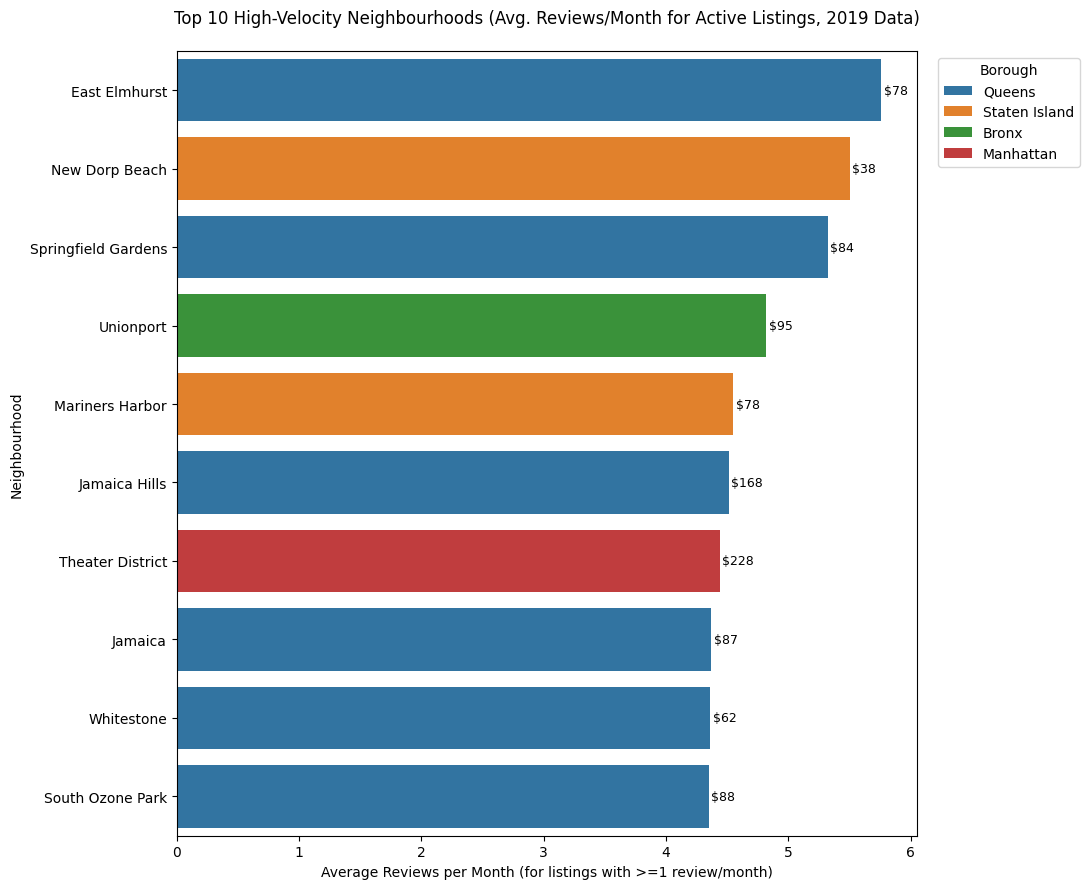


--- Q4 (Investor): Top Hosts by High-Availability Listings (>200 days) ---
SQL Result:
        host_name    host_id  num_high_availability_listings  \
0    Sonder (NYC)  219517861                             300   
1      Blueground  107434423                             175   
2            Kara   30283594                              97   
3  Jeremy & Laura   16098958                              87   
4          Sonder   12243051                              85   

   avg_price_of_these_listings  
0                       253.57  
1                       306.97  
2                       277.40  
3                       212.18  
4                       212.68  

Pandas Result:
     host_id       host_name  num_high_availability_listings  \
0  219517861    Sonder (NYC)                             300   
1  107434423      Blueground                             175   
2   30283594            Kara                              97   
3   16098958  Jeremy & Laura                             

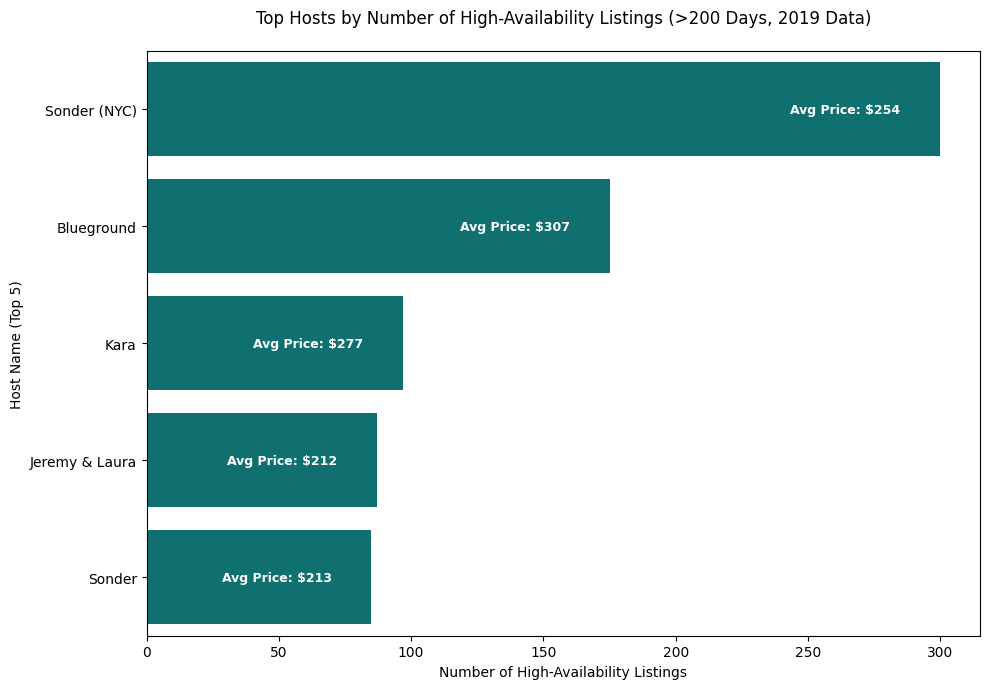


--- Q5 (Investor): Min Stay Categories vs. Price & Demand by Neighbourhood Group ---
SQL Result:
   neighbourhood_group_name    min_stay_category  number_of_listings  \
0                     Bronx   Short (1-2 nights)                 719   
1                     Bronx  Medium (3-7 nights)                 308   
2                     Bronx     Long (8+ nights)                  64   
3                  Brooklyn  Medium (3-7 nights)                7659   
4                  Brooklyn   Short (1-2 nights)                9971   
5                  Brooklyn     Long (8+ nights)                2474   
6                 Manhattan     Long (8+ nights)                4178   
7                 Manhattan  Medium (3-7 nights)                7559   
8                 Manhattan   Short (1-2 nights)                9924   
9                    Queens  Medium (3-7 nights)                1507   
10                   Queens   Short (1-2 nights)                3568   
11                   Queens     Long (

<ipython-input-11-7592d0bb85d7>:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=q5_manhattan, x='min_stay_category', y='average_price', palette='Blues', ax=ax1, order=category_order)


Saved investor_q5_visual.png


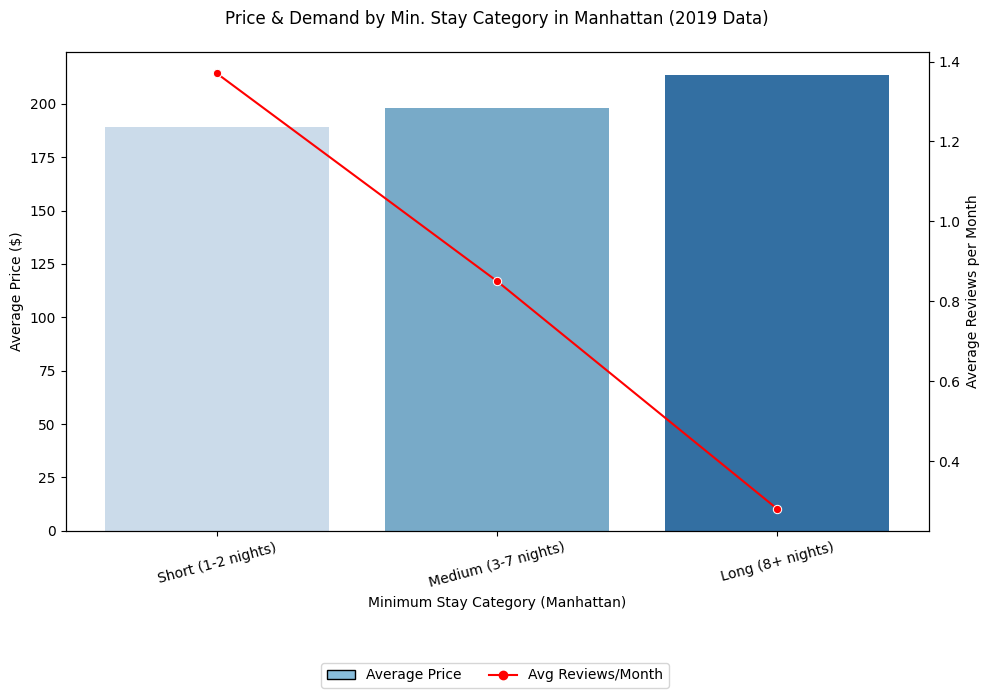


Main: Database connection closed.


In [16]:
def main():
    df_original = load_and_preprocess_data(CSV_FILE)
    if df_original is None:
        return # Stop if data loading failed

    conn_main = None
    try:
        conn_main = sqlite3.connect(DB_NAME)
        print(f"Main: Database {DB_NAME} connected.")

        if not setup_database_schema(conn_main):
            print("Main: Database schema setup failed. Exiting.")
            return

        #Populating dimension tables and get maps
        # Note: df_original is passed to this function
        maps = populate_dimension_tables(conn_main, df_original)
        if not maps["n_map"] or not maps["rt_map"]: # Check if essential maps were created
             print("Main: Essential mapping dictionaries (n_map, rt_map) were not created. Listings population might fail or be inaccurate.")
             # Decide whether to proceed or exit; for now, we proceed but with a warning.

        #Populating listings table
        # df_original is used again here. Maps are passed.
        listings_populated_successfully = populate_listings_table(conn_main, df_original, maps["n_map"], maps["rt_map"])

        if not listings_populated_successfully:
            print("Main: Listings table was not populated successfully. Analysis results may be empty or incorrect.")

        #Loading helper DataFrames from the now populated DB for analysis functions
        analysis_helpers = load_analysis_helper_dfs(conn_main)

        #Checking if Listings table has data before running analyses
        cursor_main = conn_main.cursor()
        cursor_main.execute("SELECT COUNT(*) FROM Listings")
        listings_count = cursor_main.fetchone()[0]
        cursor_main.close()

        if listings_count > 0:
            print(f"\nMain: Listings table has {listings_count} entries. Proceeding with analysis.")
            run_q1_analysis(conn_main, analysis_helpers)
            run_q2_analysis(conn_main, analysis_helpers)
            run_q3_analysis(conn_main, analysis_helpers)
            run_q4_analysis(conn_main, analysis_helpers)
            run_q5_analysis(conn_main, analysis_helpers)
        else:
            print("\nMain: Listings table is empty in the database. Skipping detailed analysis questions.")

    except sqlite3.Error as e:
        print(f"Main: An SQLite error occurred: {e}")
    except Exception as e:
        print(f"Main: An unexpected error occurred: {e}")
    finally:
        if conn_main:
            conn_main.close()
            print("\nMain: Database connection closed.")

if __name__ == '__main__':
    main()
else:
    main()